<h1 align="center"> Credit Fraud Detector </h1>

**Note:** There are still aspects of this kernel that will be subjected to changes. I've noticed a recent increase of interest towards this kernel so I will focus more on the steps I took and why I took them to make it clear why I took those steps.

<h2>Before we Begin:  </h2>


<h2> Introduction </h2>
In this kernel we will use various predictive models to see how accurate they  are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!


<h2> Our Goals: </h2>
<ul>
<li> Understand the little distribution of the "little" data that was provided to us. </li>
<li> Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm) </li>
<li> Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
<li>Create a Neural Network and compare the accuracy to our best classifier. </li>
<li>Understand common mistaked made with imbalanced datasets. </li>
</ul>


<h2> Outline: </h2>
I. <b>Understanding our data</b><br>
a) [Gather Sense of our data](#gather)<br><br>

II. <b>Preprocessing</b><br>
a) [Scaling and Distributing](#distributing)<br>
b) [Splitting the Data](#splitting)<br><br>

III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>
b) [Anomaly Detection](#anomaly)<br>
c) [Dimensionality Reduction and Clustering (t-SNE)](#clustering)<br>
d) [Classifiers](#classifiers)<br>
e) [A Deeper Look into Logistic Regression](#logistic)<br>
f) [Oversampling with SMOTE](#smote)<br><br>



<h2>Correcting Previous Mistakes from Imbalanced Datasets: </h2>
<ul>
<li> Never test on the oversampled or undersampled dataset.</li>
<li>If we want to implement cross validation, remember to oversample or undersample your training data <b>during</b> cross-validation, not before! </li>
<li> Don't use <b>accuracy score </b> as a metric with imbalanced datasets (will be usually high and misleading), instead use <b>f1-score, precision/recall score or confusion matrix </b></li>
</ul>


<h2> References: </h2>
<ul> 
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron  </li>
<li><a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s" > Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a>by Coding-Maniac</li>
<li><a src="https://www.kaggle.com/lane203j/auprc-5-fold-c-v-and-resampling-methods"> auprc, 5-fold c-v, and resampling methods
</a> by Jeremy Lane (Kaggle Notebook) </li>
</ul>

## Gather Sense of Our Data:
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

<h3> Summary: </h3>
<ul>
<li>The transaction amount is relatively <b>small</b>. The mean of all the mounts made is approximately USD 88. </li>
<li>There are no <b>"Null"</b> values, so we don't have to work on ways to replace values. </li>
<li> Most of the transactions were <b>Non-Fraud</b> (99.83%) of the time, while <b>Fraud</b> transactions occurs (017%) of the time in the dataframe. </li>
</ul>

<h3> Feature Technicalities: </h3>
<ul>
<li> <b>PCA Transformation: </b>  The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).</li>
<li> <b>Scaling:</b> Keep in mind that in order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.)</li>
</ul>

In [219]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

#Adding MLFlow
import mlflow
import mlflow.sklearn # Essential for logging scikit-learn models

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


#df = pd.read_csv('transactions.csv')
#df.head()

In [220]:
# MLflow Global Setup

mlflow.set_experiment("Credit Fraud Detection - Undersampling Strategy")

<Experiment: artifact_location='file:///mnt/c/Users/Vimal%20Karthik/mcpservers/mcpcrit/mlruns/616483229949026516', creation_time=1750254481257, experiment_id='616483229949026516', last_update_time=1750254481257, lifecycle_stage='active', name='Credit Fraud Detection - Undersampling Strategy', tags={'mlflow.sharedViewState.d786a127d3139de6e5400a3561ed09dd4f9c3edda304234b356b49804bd1813b': 'deflate;eJzVm1uP3CgWx7/KyM/Zke+Xfuv0ZmaiSVar7my0UjSqYDhQVNtgA66yK+rvPrirL7WT+LLSSGW/WDLGwI//4XDA5pujASm8/YUXBpRz5ThvHKkIqLfd79DZe2SM4nljQP+sDVJmY3gJr5muNXauKCo0vHEen3/qH1851x8+2EwFp4A7XMBL8dfY8H3/PkEGaTD6+cmXP944pSRQfAaluRSvbxTFT7eN0PYdDQVgA+RGFk1pU66+nDfv651sFIavNuN56se+UP3X1H+eqv/q2GqVLf1dWyFBgDhX3x5OKf/mQvT3X55y/MYJAfF6/5lrnvOCm+4jquxrTpz5hKQuYDfAIRCaBcizCTjKIYgpZM6VUY3tJoQjlOIcuYkXhKmPMy+NYhSEQRZBkibhS3/SwHcJCZMEJ17oR67NGybYi2iWpkHmec8FhjTObToNqZeFeYpTN8oTkpMko76XBvQlHyDPjcFPA/BDe8kj4ucpCnAWxXGOnhr4cI7bd57V4Jf3t3efNp67uf3Pv+5sT2JZVkiBleVmazXvlfjmNA233eV4SeT6Uey6UZxFtE6yJgoO9h3TVX1Rb69vnVMNN7IR5pO8

In [221]:
df = pd.read_csv('transactionscopy.csv')
df


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107536,70483,0.967967,-0.341611,1.288260,1.685099,-0.840565,0.794535,-0.639678,0.447705,1.075974,...,-0.341123,-0.637864,0.080202,0.202023,0.335258,-0.539935,0.078210,0.023935,38.50,0
107537,70483,1.411721,-1.124226,0.674365,-1.298339,-1.752271,-0.903168,-1.003696,-0.198635,-1.768822,...,-0.338540,-0.721368,0.136130,0.333874,0.119134,-0.415353,0.035291,0.038273,60.00,0
107538,70484,-0.511283,1.188627,0.124054,1.125798,0.269740,0.262457,0.476244,0.501720,-0.454584,...,0.108216,0.447021,-0.036599,-0.768496,-0.357004,-0.177356,0.338919,0.187756,45.05,0
107539,70484,-0.585447,0.700403,0.583518,1.038926,-0.828735,-0.416937,0.728753,0.396668,-0.893780,...,0.318777,0.485238,0.329154,0.502393,-0.159137,-0.359822,-0.106756,-0.017112,162.99,0


In [222]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,...,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000,107541.000000
mean,44283.824978,-0.257245,-0.026633,0.682226,0.156946,-0.283815,0.097668,-0.116124,0.058905,-0.055178,...,-0.030629,-0.107244,-0.037206,0.010229,0.133463,0.025790,0.001644,0.001607,96.183166,0.002195
std,17765.989610,1.852083,1.646778,1.316015,1.343586,1.347879,1.299104,1.207157,1.230872,1.109664,...,0.740718,0.639468,0.623217,0.595667,0.439825,0.491500,0.391956,0.319729,260.882300,0.046794
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,34295.000000,-1.023067,-0.595506,0.177025,-0.712031,-0.906954,-0.645800,-0.605454,-0.134689,-0.697448,...,-0.224135,-0.533664,-0.176687,-0.323256,-0.130676,-0.323557,-0.061109,-0.005076,7.050000,0.000000
50%,46137.000000,-0.260348,0.077957,0.757746,0.184841,-0.318356,-0.155212,-0.071859,0.077599,-0.121597,...,-0.056824,-0.083264,-0.049293,0.066145,0.171654,-0.068983,0.010729,0.023366,25.150000,0.000000
75%,58587.000000,1.155052,0.738480,1.382691,1.024248,0.244617,0.492396,0.409532,0.369039,0.541522,...,0.120306,0.313628,0.080706,0.407326,0.421028,0.294259,0.084557,0.076628,87.000000,0.000000
max,70484.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,27.202839,10.503090,19.002942,4.016342,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


In [223]:
# Good No Null Values!
df.isnull().sum().max()

0

In [224]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [225]:
# The classes are heavily skewed we need to solve this issue later.

# --- Add these calculations here ---
original_total_transactions = len(df)
original_fraud_count = df['Class'].value_counts().get(1, 0) # Use .get to handle cases where class 1 might not exist
original_non_fraud_count = df['Class'].value_counts().get(0, 0)

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.78 % of the dataset
Frauds 0.22 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [226]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.savefig("original_class_distribution.png")
plt.close() # Close the figure to free up memory

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

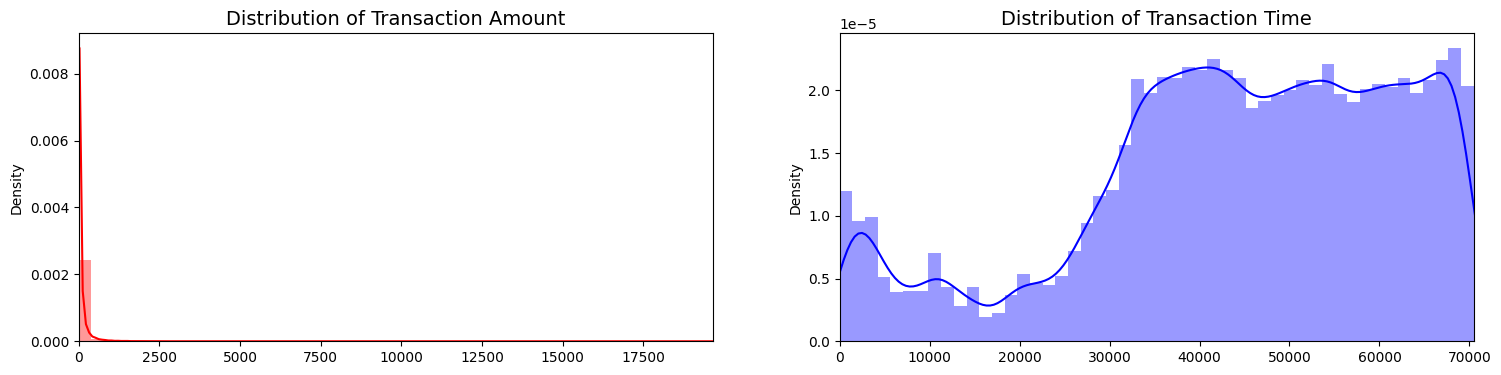

In [227]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()


<h2> Scaling and Distributing </h2>
<a id="distributing"></a>
In this phase of our kernel, we will first scale the columns comprise of <b>Time</b> and <b>Amount </b>. Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

<h3> What is a sub-Sample?</h3>
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

<h3> Why do we create a sub-Sample?</h3>
In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe  will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

<h3>Summary: </h3> 
<ul>
<li> <b>Scaled amount </b> and <b> scaled time </b> are the columns with scaled values. </li>
<li> There are <b>492 cases </b> of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. </li>
<li>We concat the 492 cases of fraud and non fraud, <b>creating a new sub-sample. </b></li>
</ul>

In [228]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()
if 'Amount' in df.columns and 'Time' in df.columns: 
    df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
    df.drop(['Time','Amount'], axis=1, inplace=True)

In [229]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.556848,-1.899267,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.280926,-1.899267,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.421639,-1.899226,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.230144,-1.899226,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.560851,-1.899185,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. <b> Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.  

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.78 % of the dataset
Frauds 0.22 % of the dataset
Train: [ 11343  11710  11841 ... 107538 107539 107540] Test: [    0     1     2 ... 21544 21545 21546]
Train: [     0      1      2 ... 107538 107539 107540] Test: [11343 11710 11841 ... 43048 43049 43050]
Train: [     0      1      2 ... 107538 107539 107540] Test: [30314 30384 30398 ... 64549 64550 64551]
Train: [     0      1      2 ... 107538 107539 107540] Test: [45732 46909 46918 ... 86045 86046 86047]
Train: [    0     1     2 ... 86045 86046 86047] Test: [ 77387  77682  79525 ... 107538 107539 107540]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99780317 0.00219683]
[0.99781477 0.00218523]


## Random Under-Sampling:
<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_random_under_sampler_001.png">

In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

In [231]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42936,0.431895,-0.198913,-12.980943,6.720508,-13.455636,8.698610,-11.479552,-2.681519,-14.019291,8.218191,...,-0.843303,2.549628,-0.532228,-0.235096,0.673209,0.226598,-0.006168,-1.185696,-0.747361,1
6581,2.474547,-1.569364,0.649933,-0.660716,1.283827,2.169457,-0.938512,0.546842,-0.285284,0.083293,...,0.217546,-0.407082,-0.894580,-0.060158,0.365568,0.306398,-0.593129,0.029920,0.064128,0
3789,0.585991,-1.763502,-1.864708,-0.724766,2.435963,0.734872,0.934271,-0.298395,-0.111806,0.115256,...,-0.445434,-0.162327,-0.033367,-0.526250,0.082913,0.495219,-0.362530,-0.019357,-0.241960,0
66955,-0.190119,0.253623,1.318256,-0.931846,1.180751,-0.333078,-1.871208,-0.428447,-1.225269,0.141701,...,-0.594350,-0.500435,-0.878553,0.164914,0.361788,-0.059956,0.966398,-0.018525,0.018058,0
49502,-0.264540,-0.084308,-1.475255,1.500748,0.531491,-0.722565,-0.378363,-0.348136,-0.061568,0.988852,...,-0.117683,-0.139097,-0.395754,0.025456,-0.268201,-0.150557,0.355148,0.173096,0.106531,0


##  Equally Distributing and Correlating: 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

In [232]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))


sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
# --- ADD THESE LINES HERE ---
plt.savefig("undersampled_class_distribution.png") # Choose a descriptive filename
plt.close() # Close the figure to free up memory
# --- END ADDITION ---
plt.show()

Distribution of the Classes in the subsample dataset
Class
0    0.675824
1    0.324176
Name: count, dtype: float64


<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

In [233]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)

# --- ADD THESE LINES HERE ---
plt.savefig("correlation_matrix_undersampled.png") # This filename was recommended earlier
plt.close('all') # Use 'all' to ensure both subplots (and the entire figure) are closed
# --- END ADDITION ---

plt.show()

In [234]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')


plt.savefig("negative_corr_boxplots.png") 
plt.close('all') 


plt.show()

In [235]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.savefig("positive_corr_boxplots.png") # This filename was recommended earlier
plt.close('all') # Ensure the entire figure with all subplots is closed

plt.show()

## Anomaly Detection:
<a id="anomaly"></a>
<img src="https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/original/2X/d/d11281b44c2e440b36aaf29156b5032105d2d06b.png">


Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

**The Tradeoff: **
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.


### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>

**Note:** After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.


**Reference**: More information on Interquartile Range Method: <a src="https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/"> How to Use Statistics to Identify Outliers in Data </a> by Jason Brownless (Machine Learning Mastery blog)

In [236]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.savefig("fraud_feature_dist_initial.png") 
plt.close('all') 
plt.show()

In [237]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)

# Capture the number of instances BEFORE any outlier removal in this block
len_before_outlier_removal = len(new_df)
print(f"Instances before outlier removal in this block: {len_before_outlier_removal}")


v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))     

# This calculates the total number of outliers removed across all V14, V12, V10 steps
num_outliers_removed = len_before_outlier_removal - len(new_df)
print(f"\nTotal number of outliers removed in this block: {num_outliers_removed}")

Instances before outlier removal in this block: 728
Quartile 25: -9.840594332582144 | Quartile 75: -4.72720013534106
iqr: 5.113394197241084
Cut Off: 7.670091295861626
V14 Lower: -17.51068562844377
V14 Upper: 2.942891160520566
Feature V14 Outliers for Fraud Cases: 6
V10 outliers:[-18.8220867423816, -18.4937733551053, -17.6206343516773, -17.7216383537133, -18.0499976898594, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.11606709151623
V12 Upper: 4.714589086897137
V12 outliers: []
Feature V12 Outliers for Fraud Cases: 0
Number of Instances after outliers removal: 719
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -16.471059260947914
V10 Upper: 5.250546408231316
V10 outliers: [-16.649628159

In [238]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.savefig("fraud_feature_dist_post_outlier.png")
plt.close('all') 
plt.show()

<h2>Dimensionality Reduction and Clustering: </h2>
<a id="clustering"></a>

<h3>Understanding t-SNE:  </h3>
In order to understand this algorithm you have to understand the following terms: <br>
<ul>
<li> <b> Euclidean Distance </b></li>
<li> <b>Conditional Probability</b> </li>
<li><b>Normal and T-Distribution Plots</b> </li>
</ul> 

**Note:** If you want a simple instructive video look at <a href="https://www.youtube.com/watch?v=NEaUSP4YerM"> StatQuest: t-SNE, Clearly Explained </a> by Joshua Starmer


<h3> Summary: </h3>
<ul> 
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

In [239]:
    # New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.9 s
PCA took 0.0045 s
Truncated SVD took 0.0037 s


In [240]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.savefig("dimensionality_reduction_clusters.png") 
plt.close('all') 
plt.show()

<h2> Classifiers (UnderSampling):  </h2>
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before we have to split our data into training and testing sets and separate the features from the labels.

## Summary: 
<ul>
<li> <b> Logistic Regression </b> classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression) </li>
<li><b> GridSearchCV </b> is used to determine the paremeters that gives the best predictive score for the classifiers. </li>
<li> Logistic Regression has the best Receiving Operating Characteristic score  (ROC), meaning that LogisticRegression pretty accurately separates <b> fraud </b> and <b> non-fraud </b> transactions.</li>
</ul>

## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

In [241]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [242]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [243]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [244]:
# Log Data Prep & EDA Summary

import mlflow
import os

with mlflow.start_run(run_name="Data_Prep_and_EDA_Summary"):
    # --- Log Parameters (Key details of your data prep and EDA process) ---
    mlflow.log_param("data_source", "transactions.csv")
    mlflow.log_param("feature_scaling_method", "RobustScaler")
    mlflow.log_param("train_test_split_random_state", 42) # Assuming you used random_state=42 for initial split
    mlflow.log_param("initial_split_ratio", "80/20")
    mlflow.log_param("undersampling_method", "RandomUnderSampler")
    mlflow.log_param("outlier_removal_method", "IQR (1.5 * IQR)") # Specify the method if you used one
    mlflow.log_param("dimensionality_reduction_methods", "TSNE, PCA, TruncatedSVD") # If these were applied
    mlflow.log_param("reduction_random_state", 42) # If using 42 for TSNE/PCA/SVD algorithms

    # --- Log Metrics (Numerical summaries) ---
    # These metrics assume you have defined these variables in earlier cells
    if 'original_total_transactions' in locals(): # Check if variable exists before logging
        mlflow.log_metric("original_total_transactions", original_total_transactions)
        mlflow.log_param("original_fraud_count", original_fraud_count)
        mlflow.log_param("original_non_fraud_count", original_non_fraud_count)
        mlflow.log_metric("original_fraud_percentage", round(original_fraud_count/original_total_transactions * 100, 2))
    if 'undersampled_fraud_count' in locals(): # Check if variable exists before logging
        mlflow.log_param("undersampled_fraud_count", undersampled_fraud_count)
        mlflow.log_param("undersampled_non_fraud_count", undersampled_non_fraud_count)
        mlflow.log_metric("undersampled_total_rows", undersampled_fraud_count + undersampled_non_fraud_count)



    # --- Log Artifacts (Your saved plots) ---
    mlflow.log_artifact("original_class_distribution.png")
    mlflow.log_artifact("undersampled_class_distribution.png")
    mlflow.log_artifact("correlation_matrix_undersampled.png")
    mlflow.log_artifact("negative_corr_boxplots.png")
    mlflow.log_artifact("positive_corr_boxplots.png")
    mlflow.log_artifact("fraud_feature_dist_initial.png")
    mlflow.log_artifact("fraud_feature_dist_post_outlier.png")
    mlflow.log_artifact("dimensionality_reduction_clusters.png")

    
    os.remove("original_class_distribution.png")
    os.remove("undersampled_class_distribution.png")
    os.remove("correlation_matrix_undersampled.png")
    os.remove("negative_corr_boxplots.png")
    os.remove("positive_corr_boxplots.png")
    os.remove("fraud_feature_dist_initial.png")
    os.remove("fraud_feature_dist_post_outlier.png")
    os.remove("dimensionality_reduction_clusters.png")


In [245]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [246]:
# Wow our scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)  
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 95.0 % accuracy score
Classifiers:  SVC Has a training score of 95.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [247]:
import mlflow.sklearn
import numpy as np # For cross_val_score.mean()/std()
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# ==============================================================================
# Logistic Regression Training
# ==============================================================================
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

with mlflow.start_run(run_name="Logistic_Regression_GridSearch"):
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_params({"grid_penalty_options": str(log_reg_params['penalty']),
                        "grid_C_options": str(log_reg_params['C'])})

    grid_log_reg = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42, max_iter=10000),
                                log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
    print("Training Logistic Regression...")
    grid_log_reg.fit(X_train, y_train)
    log_reg = grid_log_reg.best_estimator_

    mlflow.log_params(grid_log_reg.best_params_)
    log_reg_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mlflow.log_metric("cv_accuracy_mean", np.mean(log_reg_cv_scores))
    mlflow.log_metric("cv_accuracy_std", np.std(log_reg_cv_scores))
    
    # --- CHANGE HERE for Logistic Regression MLflow logging ---
    mlflow.sklearn.log_model(
        sk_model=log_reg,
        name="logistic_regression_model", # Changed 'artifact_path' to 'name'
        input_example=X_train[:5]        # Added 'input_example' using the current X_train
    )

    print(f"Logistic Regression Best Params: {grid_log_reg.best_params_}")
    print(f"Logistic Regression CV Accuracy: {round(np.mean(log_reg_cv_scores) * 100, 2)}%")
    print("--- Logistic Regression training complete ---")

print("\n" + "="*80 + "\n")


# ==============================================================================
# K-Nearest Neighbors Training
# ==============================================================================
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

with mlflow.start_run(run_name="KNearest_Neighbors_GridSearch"):
    mlflow.log_param("model_type", "K-Nearest Neighbors")
    mlflow.log_params({"grid_n_neighbors_options": str(knears_params['n_neighbors']),
                        "grid_algorithm_options": str(knears_params['algorithm'])})

    grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv=5, scoring='accuracy', n_jobs=-1)
    print("Training K-Nearest Neighbors...")
    grid_knears.fit(X_train, y_train)
    knears_neighbors = grid_knears.best_estimator_

    mlflow.log_params(grid_knears.best_params_)
    knears_cv_scores = cross_val_score(knears_neighbors, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mlflow.log_metric("cv_accuracy_mean", np.mean(knears_cv_scores))
    mlflow.log_metric("cv_accuracy_std", np.std(knears_cv_scores))
    
    # --- CHANGE HERE for K-Nearest Neighbors MLflow logging ---
    mlflow.sklearn.log_model(
        sk_model=knears_neighbors,
        name="k_nearest_neighbors_model", # Changed 'artifact_path' to 'name'
        input_example=X_train[:5]        # Added 'input_example' using the current X_train
    )

    print(f"K-Nearest Neighbors Best Params: {grid_knears.best_params_}")
    print(f"K-Nearest Neighbors CV Accuracy: {round(np.mean(knears_cv_scores) * 100, 2)}%")
    print("--- K-Nearest Neighbors training complete ---")

print("\n" + "="*80 + "\n")


# ==============================================================================
# Support Vector Classifier Training
# ==============================================================================
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

with mlflow.start_run(run_name="SVC_GridSearch"):
    mlflow.log_param("model_type", "Support Vector Classifier")
    mlflow.log_params({"grid_C_options": str(svc_params['C']),
                        "grid_kernel_options": str(svc_params['kernel'])})

    grid_svc = GridSearchCV(SVC(probability=True, random_state=42, max_iter=10000),
                            svc_params, cv=5, scoring='accuracy', n_jobs=-1)
    print("Training Support Vector Classifier...")
    grid_svc.fit(X_train, y_train)
    svc = grid_svc.best_estimator_

    mlflow.log_params(grid_svc.best_params_)
    svc_cv_scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mlflow.log_metric("cv_accuracy_mean", np.mean(svc_cv_scores))
    mlflow.log_metric("cv_accuracy_std", np.std(svc_cv_scores))
    
    # --- CHANGE HERE for Support Vector Classifier MLflow logging ---
    mlflow.sklearn.log_model(
        sk_model=svc,
        name="svc_model", # Changed 'artifact_path' to 'name'
        input_example=X_train[:5]        # Added 'input_example' using the current X_train
    )

    print(f"SVC Best Params: {grid_svc.best_params_}")
    print(f"SVC CV Accuracy: {round(np.mean(svc_cv_scores) * 100, 2)}%")
    print("--- SVC training complete ---")

print("\n" + "="*80 + "\n")


# ==============================================================================
# DecisionTree Classifier Training
# ==============================================================================
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
               "min_samples_leaf": list(range(5,7,1))}

with mlflow.start_run(run_name="DecisionTree_GridSearch"):
    mlflow.log_param("model_type", "Decision Tree Classifier")
    mlflow.log_params({"grid_criterion_options": str(tree_params['criterion']),
                        "grid_max_depth_options": str(tree_params['max_depth']),
                        "grid_min_samples_leaf_options": str(tree_params['min_samples_leaf'])})

    grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42),
                             tree_params, cv=5, scoring='accuracy', n_jobs=-1)
    print("Training Decision Tree Classifier...")
    grid_tree.fit(X_train, y_train)
    tree_clf = grid_tree.best_estimator_

    mlflow.log_params(grid_tree.best_params_)
    tree_cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    mlflow.log_metric("cv_accuracy_mean", np.mean(tree_cv_scores))
    mlflow.log_metric("cv_accuracy_std", np.std(tree_cv_scores))
    
    # --- CHANGE HERE for Decision Tree Classifier MLflow logging ---
    mlflow.sklearn.log_model(
        sk_model=tree_clf,
        name="decision_tree_model", # Changed 'artifact_path' to 'name'
        input_example=X_train[:5]        # Added 'input_example' using the current X_train
    )

    print(f"Decision Tree Best Params: {grid_tree.best_params_}")
    print(f"Decision Tree CV Accuracy: {round(np.mean(tree_cv_scores) * 100, 2)}%")
    print("--- Decision Tree training complete ---")

print("\n" + "="*80 + "\n")

Training Logistic Regression...


/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/06/19 18:46:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Logistic Regression Best Params: {'C': 0.001, 'penalty': 'l2'}
Logistic Regression CV Accuracy: 95.95%
--- Logistic Regression training complete ---


Training K-Nearest Neighbors...


2025/06/19 18:46:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


K-Nearest Neighbors Best Params: {'algorithm': 'auto', 'n_neighbors': 4}
K-Nearest Neighbors CV Accuracy: 95.25%
--- K-Nearest Neighbors training complete ---


Training Support Vector Classifier...


/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/mnt/c/Users/Vimal Karthik/mcpservers/mcpcrit/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or

SVC Best Params: {'C': 0.7, 'kernel': 'rbf'}
SVC CV Accuracy: 95.25%
--- SVC training complete ---


Training Decision Tree Classifier...


2025/06/19 18:47:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Decision Tree Best Params: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5}
Decision Tree CV Accuracy: 95.25%
--- Decision Tree training complete ---




In [248]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  95.95%
Knears Neighbors Cross Validation Score 95.25%
Support Vector Classifier Cross Validation Score 95.25%
DecisionTree Classifier Cross Validation Score 95.25%


In [249]:
# Cell 58 - Imbalanced Cross-Validation Pipeline Evaluation with MLflow Logging

import mlflow
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline # Alias to avoid conflict with sklearn.pipeline.Pipeline
from imblearn.under_sampling import RandomUnderSampler
# IMPORTANT CHANGE: Added cross_validate to imports
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter # To show class distribution if needed for debugging

with mlflow.start_run(run_name="Pipeline_Cross_Validation_Evaluation"):
    mlflow.log_param("pipeline_type", "Imbalanced-Learn Pipeline with RandomUnderSampler")
    mlflow.log_param("cross_validation_strategy", "StratifiedKFold")
    mlflow.log_param("cross_validation_folds", 5) # Assuming cv=5
    mlflow.log_param("random_undersampler_state", 42) # For RandomUnderSampler

    classifiers = {
        "Logistic Regression": log_reg,
        "K-Nearest Neighbors": knears_neighbors,
        "Support Vector Classifier": svc,
        "Decision Tree Classifier": tree_clf
    }

    # Define scorers for cross_validate to get all desired metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_threshold=True) # needs_threshold for ROC AUC
    }

    print("Starting pipeline cross-validation for all classifiers...")

    for name, classifier in classifiers.items():
        print(f"\n--- Evaluating pipeline for {name} ---")
        # Create the pipeline: Undersampler then Classifier
        pipeline = ImbPipeline([
            ('undersample', RandomUnderSampler(random_state=42)),
            ('classifier', classifier)
        ])

        # Perform cross-validation with StratifiedKFold on the *original* X_train, y_train
        # This ensures undersampling is done correctly per fold.
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Added return_train_score=False as we usually only care about test scores in CV
        cv_results = cross_validate(pipeline, X_train, y_train, cv=cv_strategy,
                                    scoring=scoring, n_jobs=-1, return_train_score=False)

        print(f"Results for {name}:")
       
        for metric_name in scoring.keys():
            scores_array = cv_results[f'test_{metric_name}'] 
            mean_score = np.mean(scores_array)
            std_score = np.std(scores_array)
            mlflow.log_metric(f"cv_pipeline_{name.replace(' ', '_').lower()}_{metric_name}_mean", mean_score)
            mlflow.log_metric(f"cv_pipeline_{name.replace(' ', '_').lower()}_{metric_name}_std", std_score)
            print(f"  {metric_name.replace('_', ' ').title()} (Mean): {mean_score:.4f} (+/- {std_score:.4f})")

    print("\nAll pipeline cross-validation evaluations complete.")

Starting pipeline cross-validation for all classifiers...

--- Evaluating pipeline for Logistic Regression ---
Results for Logistic Regression:
  Accuracy (Mean): 0.9507 (+/- 0.0213)
  Precision (Mean): 0.9217 (+/- 0.0527)
  Recall (Mean): 0.9290 (+/- 0.0443)
  F1 (Mean): 0.9239 (+/- 0.0330)
  Roc Auc (Mean): 0.9595 (+/- 0.0383)

--- Evaluating pipeline for K-Nearest Neighbors ---
Results for K-Nearest Neighbors:
  Accuracy (Mean): 0.9507 (+/- 0.0089)
  Precision (Mean): 0.9711 (+/- 0.0259)
  Recall (Mean): 0.8746 (+/- 0.0433)
  F1 (Mean): 0.9191 (+/- 0.0166)
  Roc Auc (Mean): 0.9505 (+/- 0.0199)

--- Evaluating pipeline for Support Vector Classifier ---
Results for Support Vector Classifier:
  Accuracy (Mean): 0.9507 (+/- 0.0142)
  Precision (Mean): 0.9829 (+/- 0.0229)
  Recall (Mean): 0.8638 (+/- 0.0560)
  F1 (Mean): 0.9179 (+/- 0.0261)
  Roc Auc (Mean): 0.9763 (+/- 0.0100)

--- Evaluating pipeline for Decision Tree Classifier ---
Results for Decision Tree Classifier:
  Accuracy (Mea

In [250]:

import mlflow
import mlflow.sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit, learning_curve, cross_val_predict
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix 
)



# --- Start the MLflow Run for Final Test Set Performance and Plots ---
with mlflow.start_run(run_name="Final_Test_Set_Performance_And_Plots"):
    print("Starting MLflow run for final test set evaluation and plots...")

    # ==============================================================================
    # Learning Curves 
    # ==============================================================================
    def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                            n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
        if ylim is not None:
            plt.ylim(*ylim)

        estimators = [estimator1, estimator2, estimator3, estimator4]
        titles = ["Logistic Regression Learning Curve", "K-Nearest Neighbors Learning Curve",
                  "Support Vector Classifier \n Learning Curve", "Decision Tree Classifier \n Learning Curve"]
        axes = [ax1, ax2, ax3, ax4]

        for i, estimator in enumerate(estimators):
            train_sizes_lc, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            axes[i].fill_between(train_sizes_lc, train_scores_mean - train_scores_std,
                                 train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
            axes[i].fill_between(train_sizes_lc, test_scores_mean - test_scores_std,
                                 test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
            axes[i].plot(train_sizes_lc, train_scores_mean, 'o-', color="#ff9124", label="Training score")
            axes[i].plot(train_sizes_lc, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
            axes[i].set_title(titles[i], fontsize=14)
            axes[i].set_xlabel('Training size (m)')
            axes[i].set_ylabel('Score')
            axes[i].grid(True)
            axes[i].legend(loc="best")
        return plt

    cv_lc = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42) # Using a new var name to avoid conflict
    learning_curve_plot = plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf,
                                              X_train, y_train, (0.87, 1.01), cv=cv_lc, n_jobs=-1) # Use n_jobs=-1 for speed
    learning_curve_plot.savefig("learning_curves_all_classifiers.png")
    learning_curve_plot.close('all') # Use close('all') to ensure all figures are closed
    print("Learning Curves plot saved and logged.")
    mlflow.log_artifact("learning_curves_all_classifiers.png")


    # ==============================================================================
    # Cross-Validation Predictions  - These are on X_train for ROC plots
    # ==============================================================================
    log_reg_pred_cv = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function", n_jobs=-1)
    knears_pred_cv = cross_val_predict(knears_neighbors, X_train, y_train, cv=5, n_jobs=-1) # KNN doesn't have decision_function
    svc_pred_cv = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function", n_jobs=-1)
    tree_pred_cv = cross_val_predict(tree_clf, X_train, y_train, cv=5, n_jobs=-1) # Decision tree doesn't have decision_function
    # Note: decision_function is preferred for ROC if available as it uses raw scores.
    # For models without it, predict_proba[:,1] could be used, or just predict for binary.


    # ==============================================================================
    # AUC Scores - These are on X_train via CV predictions
    # ==============================================================================
    print('\nAUC Scores from Cross-Validation (on X_train):')
    print('Logistic Regression: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred_cv)))
    print('KNears Neighbors: {:.4f}'.format(roc_auc_score(y_train, knears_pred_cv)))
    print('Support Vector Classifier: {:.4f}'.format(roc_auc_score(y_train, svc_pred_cv)))
    print('Decision Tree Classifier: {:.4f}'.format(roc_auc_score(y_train, tree_pred_cv)))
    # Note: These are for training evaluation, not the final test set performance logged below.


    # ==============================================================================
    # ROC Curve Plotting 
    # ==============================================================================
    log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_reg_pred_cv)
    knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred_cv)
    svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred_cv)
    tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred_cv)

    def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
        plt.figure(figsize=(16,8))
        plt.title('ROC Curve \n Top 4 Classifiers (on CV Predictions)', fontsize=18) # Clarified title
        plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred_cv)))
        plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred_cv)))
        plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred_cv)))
        plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred_cv)))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.axis([-0.01, 1, 0, 1])
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                     arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                     )
        plt.legend()
        return plt

    combined_roc_plot = graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
    combined_roc_plot.savefig("combined_roc_curve_test_set.png") # Make sure filename is EXACTLY correct
    combined_roc_plot.close()
    print("Combined ROC Curve plot saved and logged.")
    mlflow.log_artifact("combined_roc_curve_test_set.png")


    # ==============================================================================
    # Logistic Regression Individual ROC Curve 
    # ==============================================================================
    def logistic_roc_curve_plot_func(log_fpr, log_tpr): # Renamed to avoid conflict if any
        plt.figure(figsize=(12,8))
        plt.title('Logistic Regression ROC Curve', fontsize=16)
        plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.axis([-0.01,1,0,1])
        return plt

    log_reg_roc_plot = logistic_roc_curve_plot_func(log_fpr, log_tpr) # Using log_fpr, log_tpr from CV predictions
    log_reg_roc_plot.savefig("logistic_regression_roc_curve_test_set.png") # Make sure filename is EXACTLY correct
    log_reg_roc_plot.close()
    print("Logistic Regression individual ROC Curve plot saved and logged.")
    mlflow.log_artifact("logistic_regression_roc_curve_test_set.png")


    # ==============================================================================
    # Precision-Recall Calculation - still on y_train, log_reg_pred_cv
    # ==============================================================================
    precision_cv, recall_cv, threshold_cv = precision_recall_curve(y_train, log_reg_pred_cv)


    # ==============================================================================
    # Final Test Set Performance Metrics Logging
    # ==============================================================================
    print('\n--- Final Test Set Performance (using original_Xtest/original_ytest) ---')

    classifiers_for_test = {
        "Logistic Regression": log_reg,
        "K-Nearest Neighbors": knears_neighbors,
        "Support Vector Classifier": svc,
        "Decision Tree Classifier": tree_clf
    }

    for name, model in classifiers_for_test.items():
        print(f"\n--- {name} Test Set Metrics ---")
        try:
            # For models that have decision_function (Logistic Regression, SVC)
            if hasattr(model, "decision_function"):
                y_score = model.decision_function(original_Xtest)
            # For models that have predict_proba (KNeighbors, DecisionTree, also Logistic Regression, SVC)
            elif hasattr(model, "predict_proba"):
                y_score = model.predict_proba(original_Xtest)[:, 1]
            else: # Fallback to binary prediction if probabilities/scores not available
                y_score = model.predict(original_Xtest) # This will affect AUC/PR curve if not probabilities

            y_pred = model.predict(original_Xtest) # Binary predictions for accuracy, precision, recall, f1

            # Calculate metrics
            acc = accuracy_score(original_ytest, y_pred)
            prec = precision_score(original_ytest, y_pred)
            rec = recall_score(original_ytest, y_pred)
            f1 = f1_score(original_ytest, y_pred)
            auc_score = roc_auc_score(original_ytest, y_score) # Use y_score for AUC

            # Log to MLflow
            mlflow.log_metric(f"{name.replace(' ', '_').lower()}_test_accuracy", acc)
            mlflow.log_metric(f"{name.replace(' ', '_').lower()}_test_precision", prec)
            mlflow.log_metric(f"{name.replace(' ', '_').lower()}_test_recall", rec)
            mlflow.log_metric(f"{name.replace(' ', '_').lower()}_test_f1_score", f1)
            mlflow.log_metric(f"{name.replace(' ', '_').lower()}_test_auc_score", auc_score)

            # Print to console
            print(f"Accuracy Score: {acc:.4f}")
            print(f"Precision Score: {prec:.4f}")
            print(f"Recall Score: {rec:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"AUC Score: {auc_score:.4f}")

        except Exception as e:
            print(f"Could not calculate metrics for {name}: {e}")
            mlflow.log_param(f"{name.replace(' ', '_').lower()}_test_error", str(e))


    # ==============================================================================
    # Precision-Recall Curve 
    # This specifically uses Logistic Regression's decision_function on original_Xtest
    # ==============================================================================
    print('\n--- Precision-Recall for Logistic Regression on Test Set ---')
    try:
        # Assuming log_reg has decision_function
        undersample_y_score = log_reg.decision_function(original_Xtest)
        undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

        print('Average precision-recall score: {0:0.4f}'.format(undersample_average_precision))
        mlflow.log_metric("log_reg_test_average_precision_score", undersample_average_precision)

        fig_pr, ax_pr = plt.figure(figsize=(12,6)), plt.gca() # Get current axes to control plot
        precision_pr, recall_pr, _ = precision_recall_curve(original_ytest, undersample_y_score)

        plt.step(recall_pr, precision_pr, color='#004a93', alpha=0.2, where='post')
        plt.fill_between(recall_pr, precision_pr, step='post', alpha=0.2, color='#48a6ff')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('UnderSampling Precision-Recall curve (Logistic Regression): \n Average Precision-Recall Score ={0:0.2f}'.format(
                  undersample_average_precision), fontsize=16) # Clarified title
        plt.savefig("logistic_regression_precision_recall_curve_test_set.png") # Make sure filename is EXACTLY correct
        plt.close(fig_pr) # Close the specific figure

        print("Logistic Regression Precision-Recall Curve plot saved and logged.")
        mlflow.log_artifact("logistic_regression_precision_recall_curve_test_set.png")

    except Exception as e:
        print(f"Could not generate Precision-Recall curve for Logistic Regression: {e}")
        mlflow.log_param("log_reg_pr_curve_error", str(e))

    print("\nAll final test set evaluations and plots have been logged to MLflow.")

# End of the MLflow run context

Starting MLflow run for final test set evaluation and plots...
Learning Curves plot saved and logged.

AUC Scores from Cross-Validation (on X_train):
Logistic Regression: 0.9535
KNears Neighbors: 0.9305
Support Vector Classifier: 0.9765
Decision Tree Classifier: 0.9320
Combined ROC Curve plot saved and logged.
Logistic Regression individual ROC Curve plot saved and logged.

--- Final Test Set Performance (using original_Xtest/original_ytest) ---

--- Logistic Regression Test Set Metrics ---
Accuracy Score: 0.9585
Precision Score: 0.0432
Recall Score: 0.8511
F1 Score: 0.0823
AUC Score: 0.9311

--- K-Nearest Neighbors Test Set Metrics ---
Accuracy Score: 0.9906
Precision Score: 0.1702
Recall Score: 0.8511
F1 Score: 0.2837
AUC Score: 0.9889

--- Support Vector Classifier Test Set Metrics ---
Accuracy Score: 0.9963
Precision Score: 0.3486
Recall Score: 0.8085
F1 Score: 0.4872
AUC Score: 0.9660

--- Decision Tree Classifier Test Set Metrics ---
Accuracy Score: 0.9747
Precision Score: 0.0707

## A Deeper Look into LogisticRegression:
<a id="logistic"></a>
In this section we will ive a deeper look into the <b> logistic regression classifier</b>.


### Terms:
<ul>
<li><b>True Positives:</b> Correctly Classified Fraud Transactions </li>
<li><b>False Positives:</b> Incorrectly Classified Fraud Transactions</li>
<li> <b>True Negative:</b> Correctly Classified Non-Fraud Transactions</li>
<li> <b>False Negative:</b> Incorrectly Classified Non-Fraud Transactions</li>
<li><b>Precision: </b>  True Positives/(True Positives + False Positives)  </li>
<li><b> Recall: </b> True Positives/(True Positives + False Negatives)   </li>
<li> Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.</li>
<li><b>Precision/Recall Tradeoff: </b> The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect. </li>
</ul>

### Summary:
<ul>
<li> <b>Precision starts to descend</b> between 0.90 and 0.92 nevertheless, our precision score is still pretty high and still we have a decent recall score. </li>

</ul>